In [1]:
import scanpy as sc
import anndata
import os
import fnmatch
%matplotlib inline
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
#import scrublet as scr
import importlib
import sys
from harmony import harmonize
import seaborn as sns
from matplotlib import rcParams
import math
from scipy import stats
import seaborn as sns
import scipy as sp
import h5py
import warnings
import random
import math
import scvelo as scv
from matplotlib import rcParams
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap

In [2]:
#Setting Scanpy figure parameters 
sc.settings.set_figure_params(dpi = 500, color_map = 'RdPu', dpi_save = 500)

In [4]:
adata_allcells = sc.read_h5ad("./Scanpy_H5AD/adata_Final_for_Reinfection_publication.h5ad")
adata_allcells

AnnData object with n_obs × n_vars = 88360 × 25901
    obs: 'sample', 'DGE_name', 'monkey', 'array number', 'Sample Name', 'Sample type', 'Time point of sampling', 'Infusion before 2nd Mtb infection anti CD4 or IgG', 'Naïve or Primary Infection or Reinfection at sample time', 'Group', 'Group_Detailed', 'Drug Treatment', 'CFU Total ', 'Type of Mtb strain ', 'n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_hbb', 'predicted_doublets', 'color', 'SubclusteringGroup', 'Subclustering', 'Doublet', 'leiden', 'leiden_lab_orig', 'Doublet_labels', 'Doublet_colors', 'Doublet_str', 'Doublet_int'
    var: 'n_cells', 'Blacklist_Genes', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Doublet_colors_colors', 'Doublet_str_colors', 'Group_colors', 'hvg', 'leiden', 'leiden_colors', 'leiden_lab_orig_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [5]:
adata = sc.AnnData(adata_allcells.raw.X, obs=adata_allcells.obs, var=adata_allcells.raw.var, uns=adata_allcells.uns)
adata = adata[adata.obs['leiden_lab_orig'].isin(['Neutrophils']), :]
adata

View of AnnData object with n_obs × n_vars = 5566 × 26030
    obs: 'sample', 'DGE_name', 'monkey', 'array number', 'Sample Name', 'Sample type', 'Time point of sampling', 'Infusion before 2nd Mtb infection anti CD4 or IgG', 'Naïve or Primary Infection or Reinfection at sample time', 'Group', 'Group_Detailed', 'Drug Treatment', 'CFU Total ', 'Type of Mtb strain ', 'n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_hbb', 'predicted_doublets', 'color', 'SubclusteringGroup', 'Subclustering', 'Doublet', 'leiden', 'leiden_lab_orig', 'Doublet_labels', 'Doublet_colors', 'Doublet_str', 'Doublet_int'
    var: 'n_cells', 'Blacklist_Genes'
    uns: 'Doublet_colors_colors', 'Doublet_str_colors', 'Group_colors', 'hvg', 'leiden', 'leiden_colors', 'leiden_lab_orig_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'

In [6]:
adata.raw = adata.copy()
# keep blacklist genes from vars (they are stored in .raw so still accessible)
adata = adata[:,~adata.var['Blacklist_Genes']]
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata.var['highly_variable'].value_counts()
adata

AnnData object with n_obs × n_vars = 5566 × 25901
    obs: 'sample', 'DGE_name', 'monkey', 'array number', 'Sample Name', 'Sample type', 'Time point of sampling', 'Infusion before 2nd Mtb infection anti CD4 or IgG', 'Naïve or Primary Infection or Reinfection at sample time', 'Group', 'Group_Detailed', 'Drug Treatment', 'CFU Total ', 'Type of Mtb strain ', 'n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_hbb', 'predicted_doublets', 'color', 'SubclusteringGroup', 'Subclustering', 'Doublet', 'leiden', 'leiden_lab_orig', 'Doublet_labels', 'Doublet_colors', 'Doublet_str', 'Doublet_int'
    var: 'n_cells', 'Blacklist_Genes', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Doublet_colors_colors', 'Doublet_str_colors', 'Group_colors', 'hvg', 'leiden', 'leiden_colors', 'leiden_lab_orig_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'

In [ ]:
sc.tl.pca(adata, svd_solver = 'arpack', random_state = 18,use_highly_variable=True)
sc.pl.pca(adata, components=['1,2', '3,4'], color=['Group'],
          ncols=4, use_raw=True)
sc.pl.pca_loadings(adata, components=[1,2,3,4])
sc.pl.pca_variance_ratio(adata, log=True)

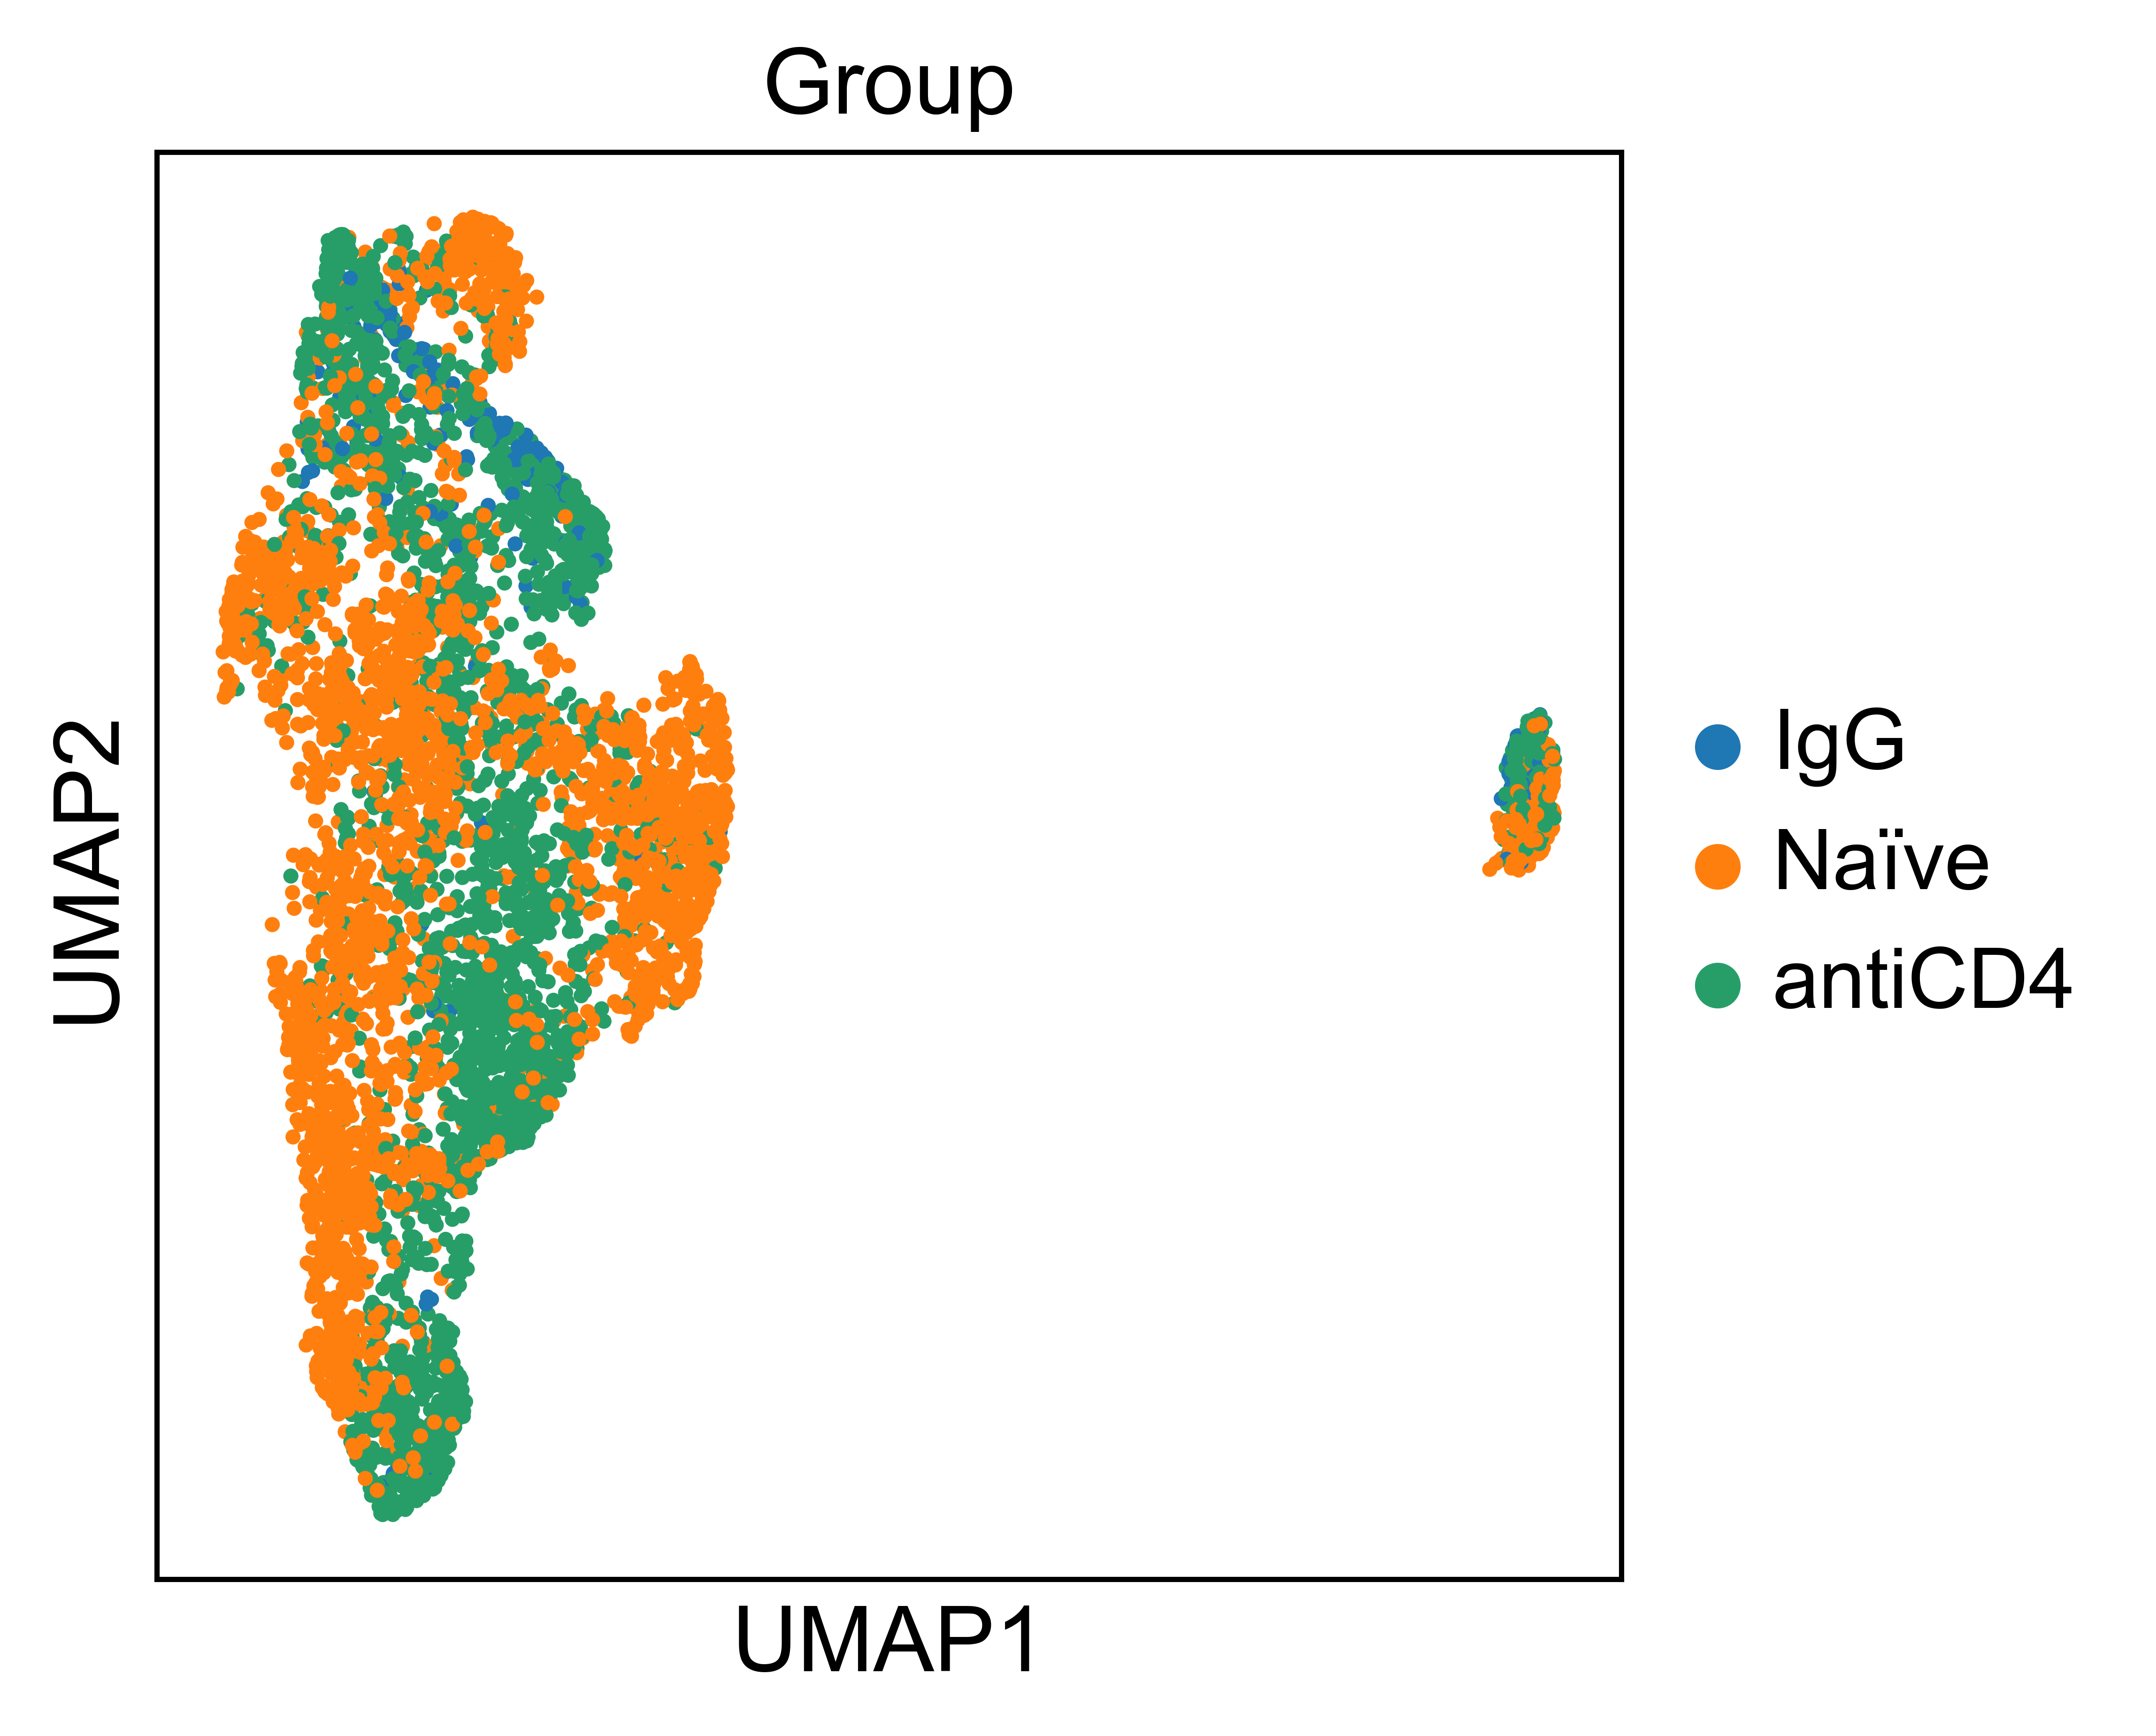

In [8]:
sc.pp.neighbors(adata, n_neighbors=40, n_pcs=10, random_state = 18)
sc.tl.umap(adata, min_dist = 0.1, spread = 2, random_state = 18)
sc.pl.umap(adata, color = ["Group"])

# 2. Determine optimal cluster resolution for cell subset annotation

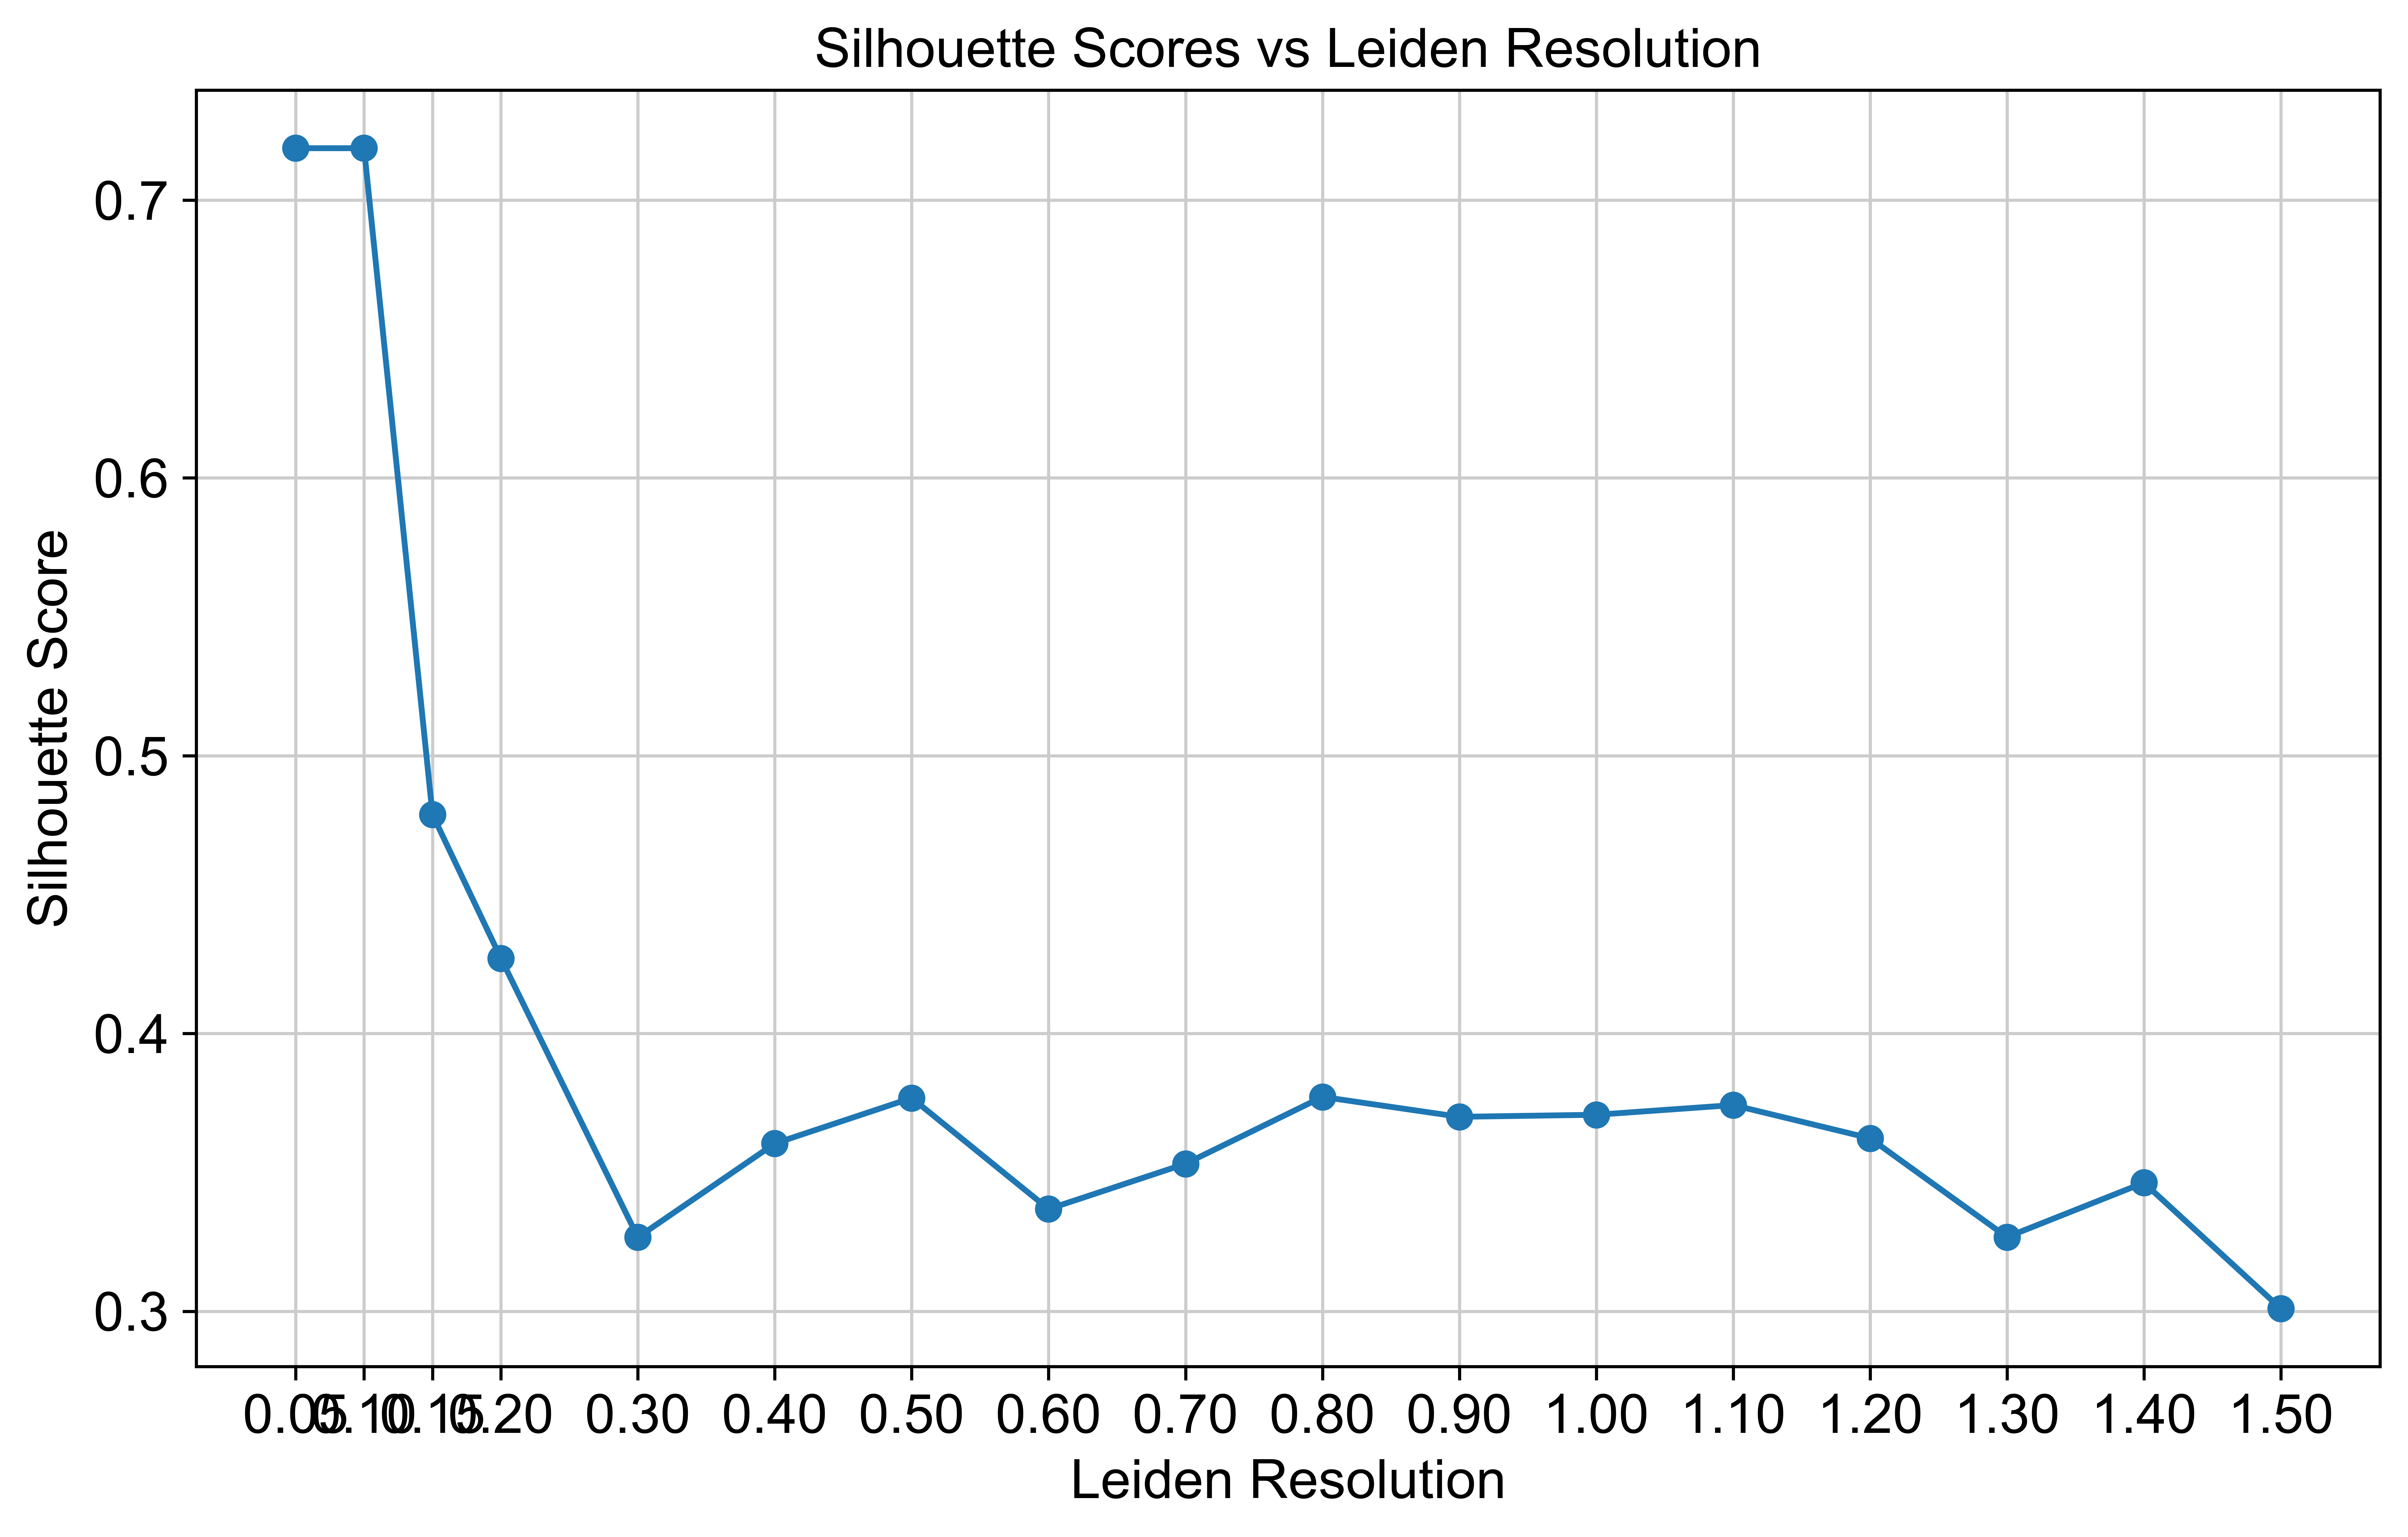

In [12]:
import sklearn
from sklearn.metrics import silhouette_score  
# define resolutions to be tested
resolutions = [0.05,0.1,0.15,0.2,0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]

silhouette_scores = []

# calculate silhouette scores for each resolution
for res in resolutions:
    sc.tl.leiden(adata, resolution=res, key_added=f"leiden_res{res}")
    
    score = sklearn.metrics.silhouette_score(adata.obsm['X_umap'], adata.obs[f"leiden_res{res}"], metric='euclidean')
    silhouette_scores.append(score)

plt.figure(figsize=(10,6))
plt.plot(resolutions, silhouette_scores, marker='o')
plt.title('Silhouette Scores vs Leiden Resolution')
plt.xlabel('Leiden Resolution')
plt.ylabel('Silhouette Score')
plt.xticks(resolutions)
plt.grid(True)
plt.show()


leiden_res0.2 is stable and has resolved a few clusters with biological significance


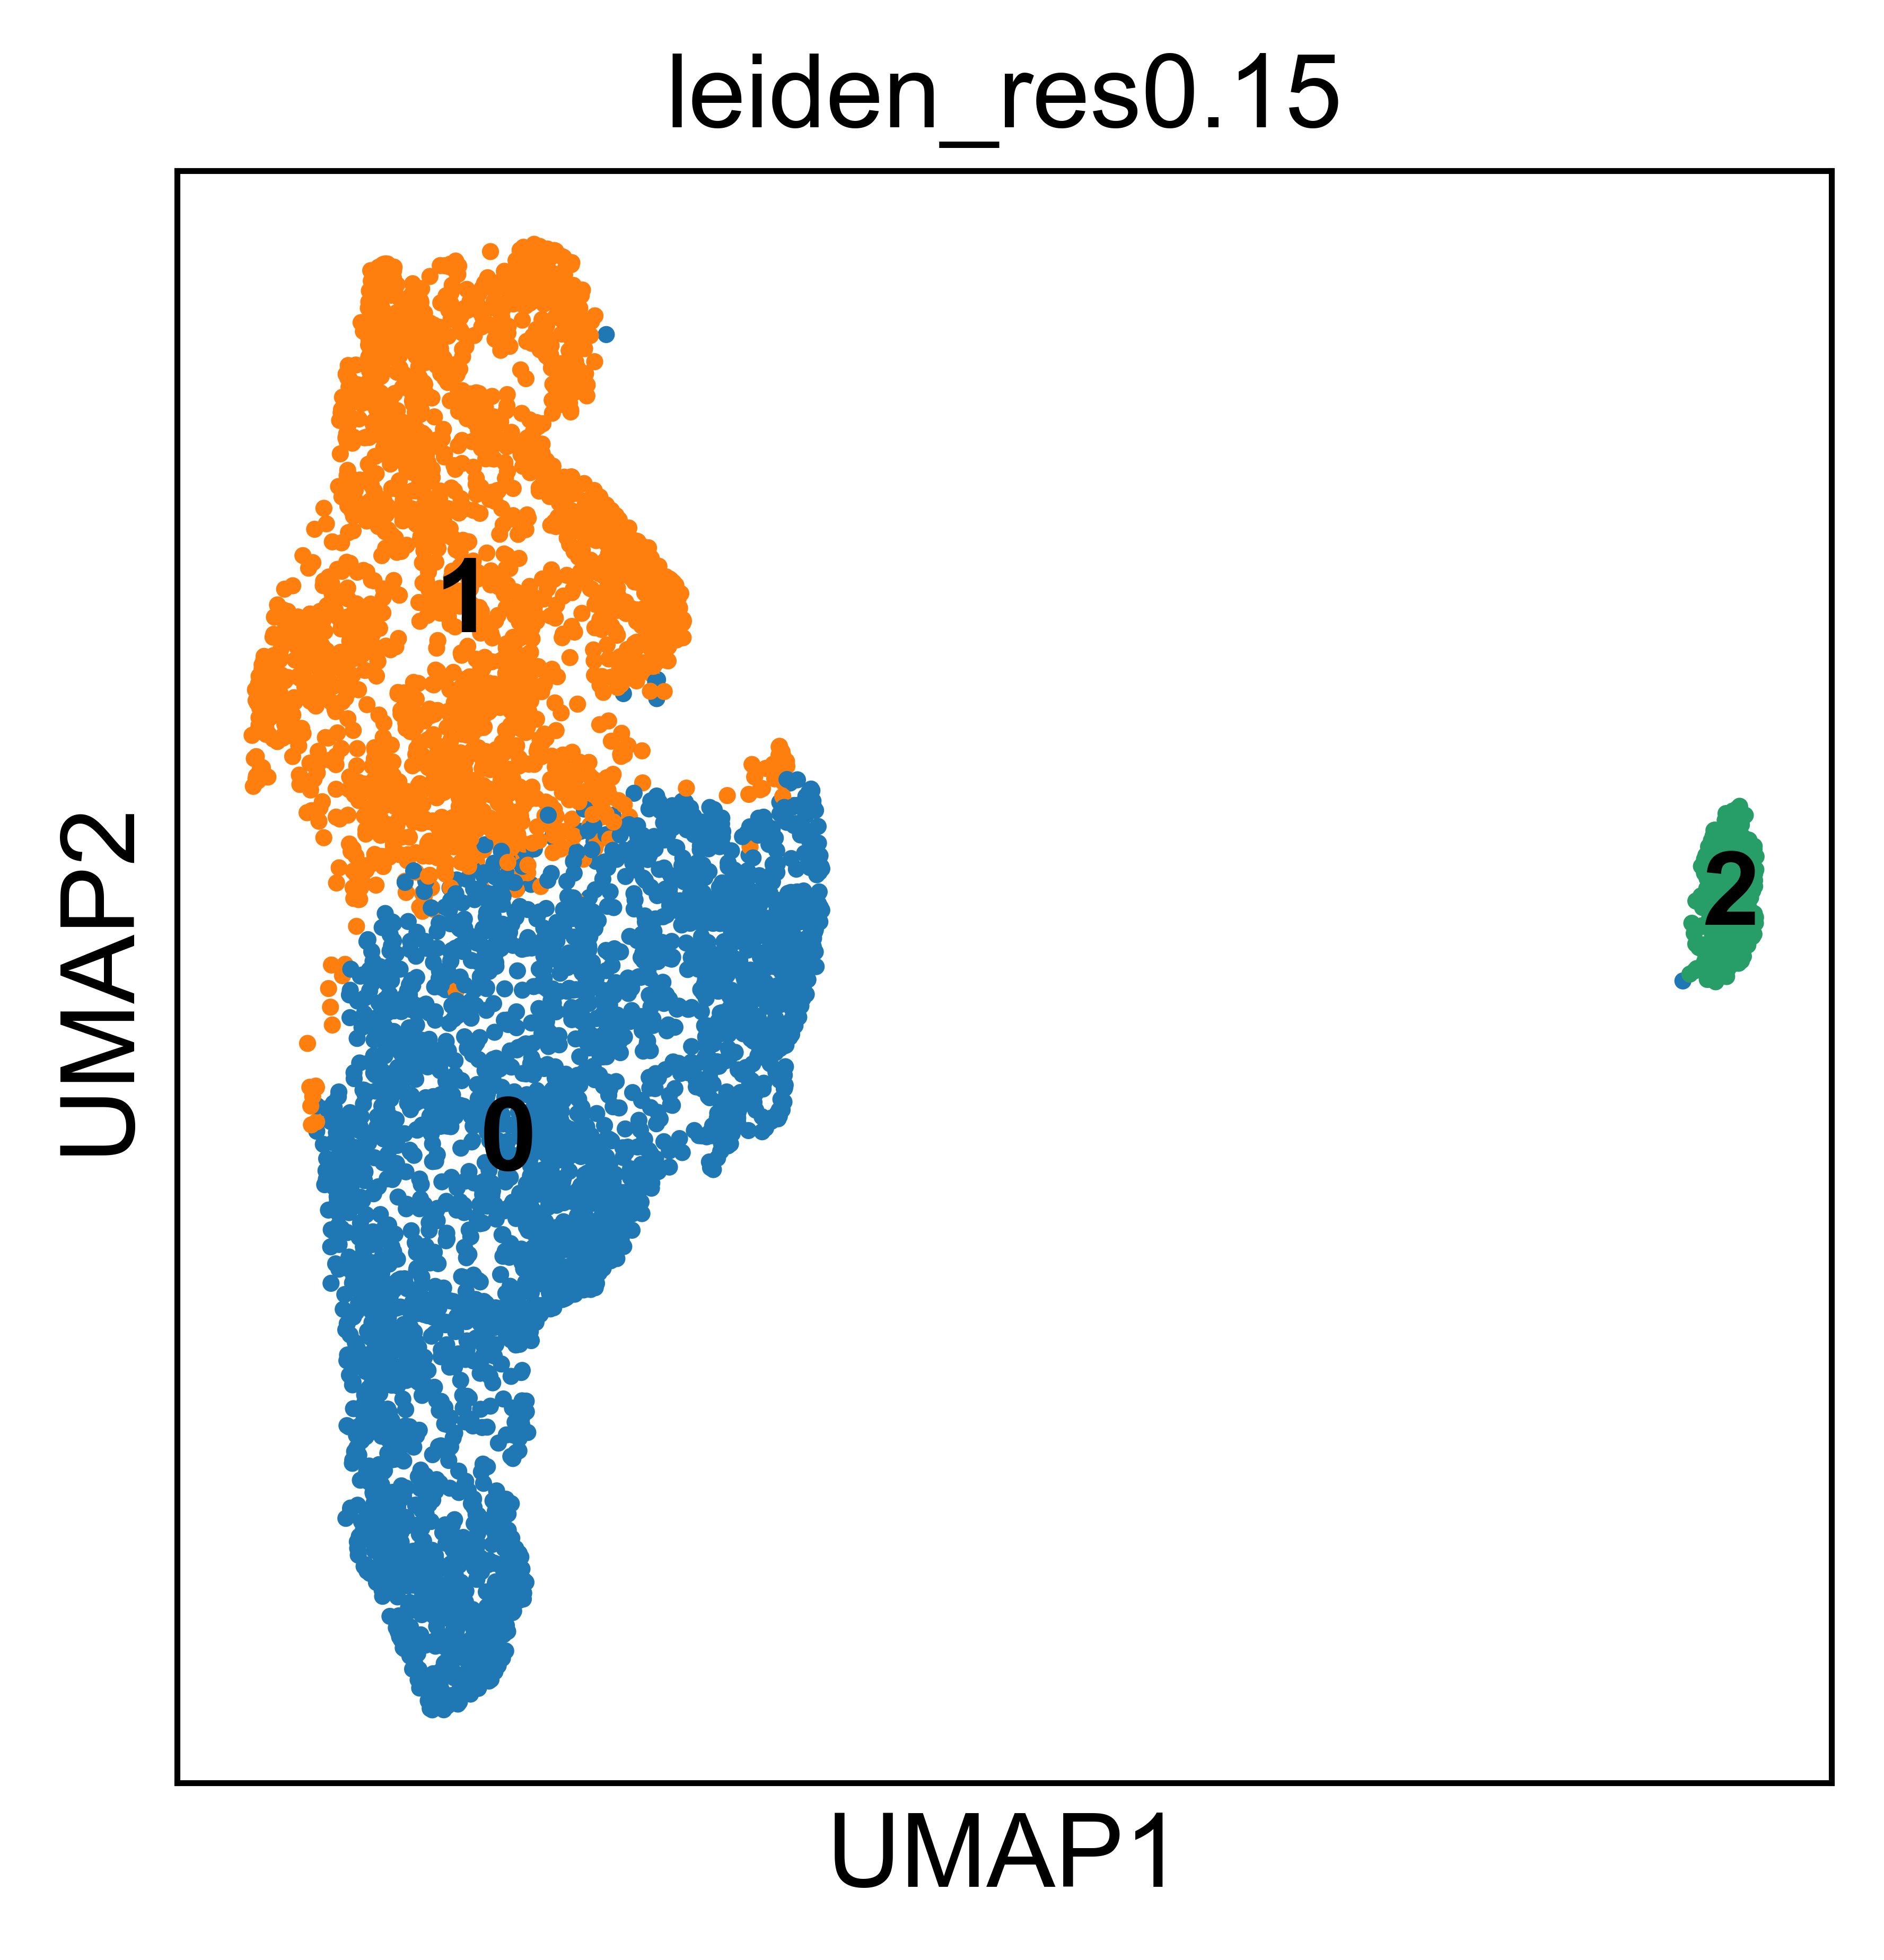

In [13]:
sc.pl.umap(adata, color = ["leiden_res0.15"],legend_loc='on data')


In [16]:
sc.pl.umap(adata, color = ["TNF","CXCL10","CCL3","CCR3"],legend_loc='on data')

In [15]:
pd.set_option('display.max_columns', None)
sc.tl.rank_genes_groups(adata, 'leiden_res0.15', method='wilcoxon')
display(pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20))

0             1             2
0          ICAM1         SORL1            F5
1   LOC102118223           CFD         FFAR3
2            NBN         PLBD1       ARHGDIB
3        GADD45B          SELL        GPR183
4           CD83  LOC102139186           TKT
5   LOC102146847          XPO6        CORO1A
6        SLC43A3  LOC102126493         SYNE1
7         NFKBIA        S100A9         COTL1
8           IDO1        RNF149          CD69
9   LOC102119743          MNDA         PLAUR
10         CD274          RGS2  LOC102141498
11  LOC102147203          VCAN          RAC2
12  LOC102119366        FAM65B        SAMSN1
13           FAS         CXCR2  LOC101865481
14        MARCKS         CCPG1  LOC102120083
15       TNFAIP6         ABHD2        AGPAT3
16           TNF           PGD        TMSB4X
17         BAZ1A         MMP25          CAMP
18         ERO1A         CXCR1          GAPT
19          GBP2       SLC11A1          ACTB

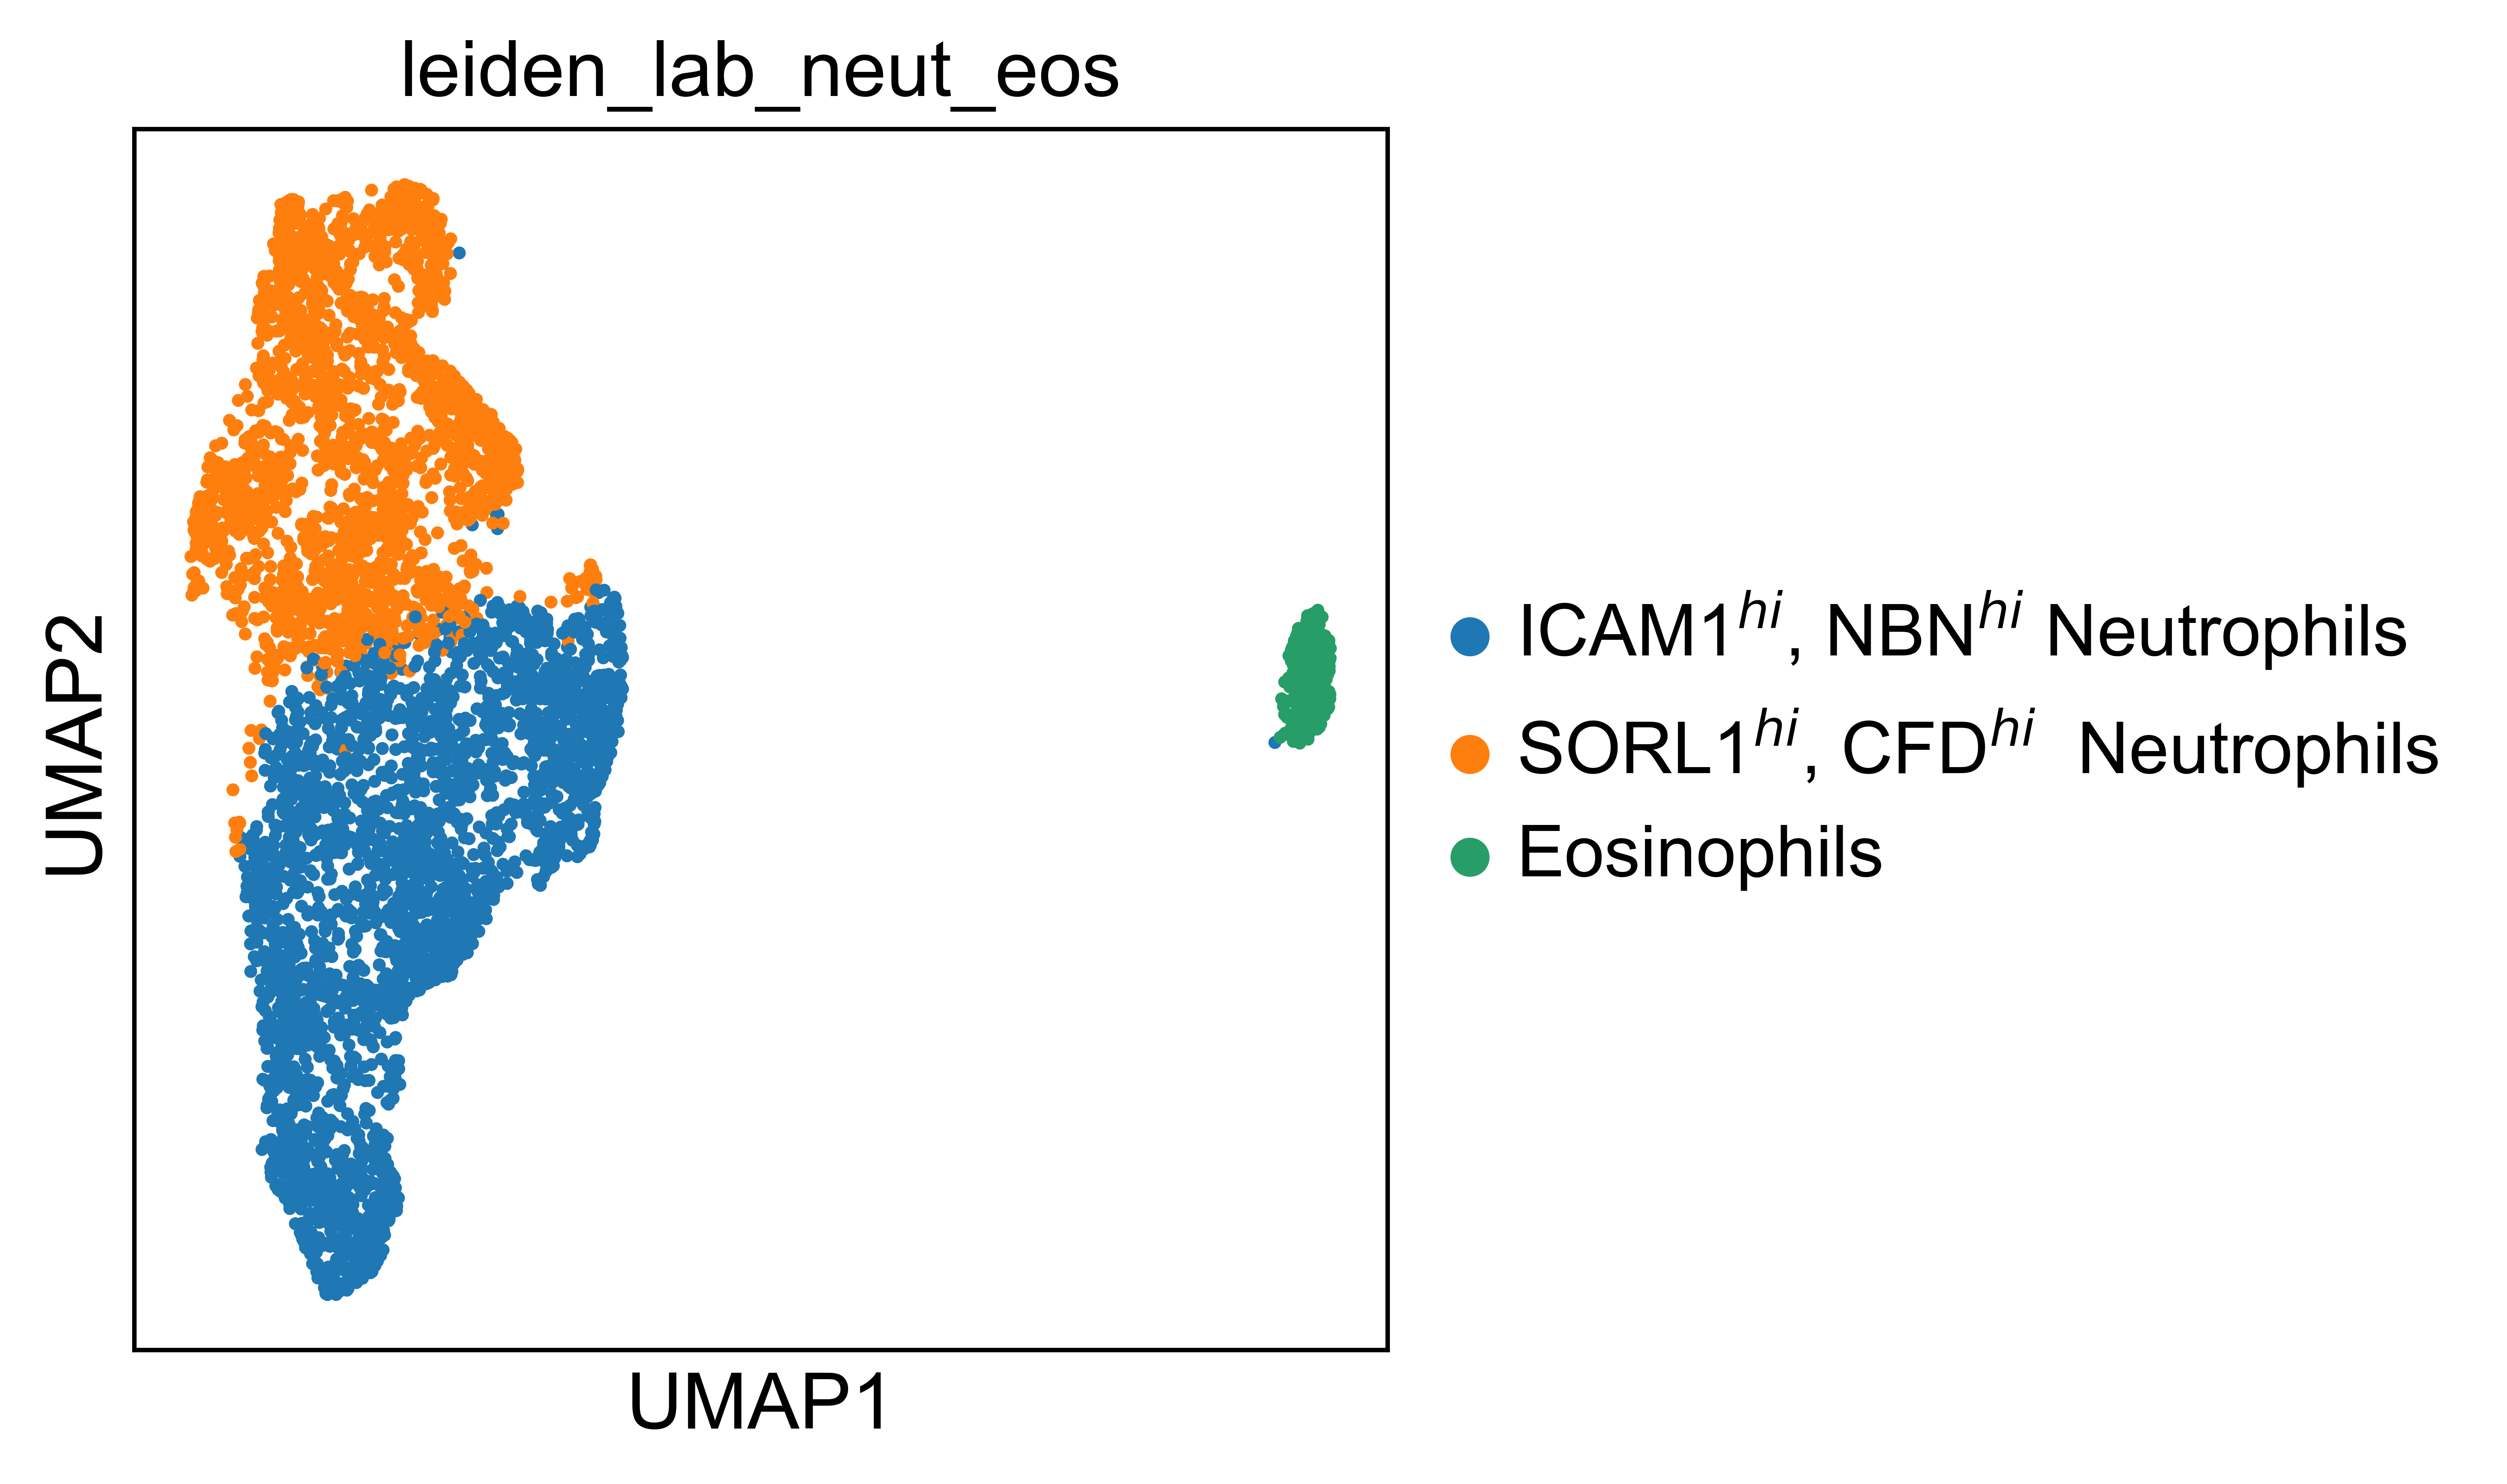

In [18]:
labmap2 = {'0':'ICAM1$^{hi}$, NBN$^{hi}$ Neutrophils',
          '1':'SORL1$^{hi}$, CFD$^{hi}$  Neutrophils',
          '2':'Eosinophils'}
adata.obs['leiden_lab_neut_eos'] = adata.obs['leiden_res0.15'].replace(labmap2)
sc.pl.umap(adata, color=['leiden_lab_neut_eos'])


In [19]:
adata_allcells.obs['Subclustering'] = adata_allcells.obs['Subclustering'].astype(str)
adata_allcells.obs.loc[adata.obs.index, 'Subclustering'] = adata.obs['leiden_lab_neut_eos']
#Save adata_allcells h5ad file w/subclustering idents
adata_allcells.write_h5ad("./Scanpy_H5AD/adata_Final_for_Reinfection_publication.h5ad")
